In [1]:
import yaw

In [2]:
ref_path = ('For_YAW/entire_reference_catalog')
rand_path = ('For_YAW/Random_catalog')
real_path = ('For_YAW/real_unknown_catalog')
fake_unkn_05_1_path = ('For_YAW/fake_unknown_catalog_05_1')
YAW_example_data_path = ('For_YAW/2dflens_kidss_data')
YAW_example_rand_path = ('For_YAW/2dflens_kidss_rand_5x')

In [3]:
ref_path+'.csv'

'For_YAW/entire_reference_catalog.csv'

In [4]:
import pandas as pd

df_ref = pd.read_csv(ref_path+'.csv')
df_fake_05_1 = pd.read_csv(fake_unkn_05_1_path+'.csv')
df_rand = pd.read_csv(rand_path+'.csv')
df_real = pd.read_csv(real_path+'.csv')

df_YAW_data = pd.read_parquet(YAW_example_data_path+'.pqt')
df_YAW_rand = pd.read_parquet(YAW_example_rand_path+'.pqt')

df_ref = df_ref.rename(columns={'redshift': 'redshifts'})

df_YAW_data = df_YAW_data.rename(columns={'RA': 'ra',
                                          'Dec': 'dec',
                                          'redshift': 'redshifts'})

df_YAW_rand = df_YAW_rand.rename(columns={'RA': 'ra',
                                          'Dec': 'dec',
                                          'redshift': 'redshifts'})

df_YAW_unkn = df_YAW_data[(df_YAW_data['redshifts'] >= 0.3) & (df_YAW_data['redshifts'] < 0.5)].sample(n = 1000, random_state=42)
df_Web_unkn = df_ref[(df_ref['redshifts'] >= 0.3) & (df_ref['redshifts'] < 0.5)].sample(n = 1000, random_state=42)

In [5]:
import numpy as np
def generate_randoms(s, e, n=1000, int = None):
    if int is not None:
        return np.random.randint(s, e, size=n)
    else:
        return np.random.uniform(s, e, size=n)

df_rand['redshifts'] = generate_randoms(0.5, 1, len(df_rand))
df_rand['patch'] = generate_randoms(0, 11, len(df_rand), int=True)
df_fake_05_1['patch'] = generate_randoms(0, 11, len(df_fake_05_1), int=True)
df_ref['patch'] = generate_randoms(0, 11, len(df_ref), int=True)
df_Web_unkn['patch'] = generate_randoms(0, 11, len(df_Web_unkn), int=True)


df_rand['wei'] = generate_randoms(0, 1, len(df_rand), int=None)
df_fake_05_1['wei'] = generate_randoms(0, 1, len(df_fake_05_1), int=None)
df_ref['wei'] = generate_randoms(0, 1, len(df_ref), int=None)
df_Web_unkn['wei'] = generate_randoms(0, 1, len(df_Web_unkn), int=None)


In [6]:
from astropy.table import Table 

table_ref = Table.from_pandas(df_ref)
#table_05_1 = Table.from_pandas(df_05_1)
table_rand = Table.from_pandas(df_rand)
table_fake_05_1 = Table.from_pandas(df_fake_05_1)
table_real = Table.from_pandas(df_real)
table_YAW_data = Table.from_pandas(df_YAW_data)
table_YAW_rand = Table.from_pandas(df_YAW_rand)
table_YAW_unkn = Table.from_pandas(df_YAW_unkn)
table_Web_unkn = Table.from_pandas(df_Web_unkn)


table_ref.write(ref_path+'.fits', format='fits', overwrite=True)
#table_05_1.write('For_YAW/fake_unknown_catalog_05_1.fits', format='fits', overwrite=True)
table_rand.write(rand_path+'.fits', format='fits', overwrite=True)
table_real.write(real_path+'.fits', format='fits', overwrite=True)
table_fake_05_1.write(fake_unkn_05_1_path+'.fits', format='fits', overwrite=True)
table_Web_unkn.write('For_YAW/Web_unkn.fits', format='fits', overwrite=True)

table_YAW_data.write(YAW_example_data_path+'.fits', format='fits', overwrite=True)
table_YAW_rand.write(YAW_example_rand_path+'.fits', format='fits', overwrite=True)
table_YAW_unkn.write(YAW_example_data_path+'unkn.fits', format='fits', overwrite=True)

In [7]:
cache_dir = "For_YAW/TEST"  # create as needed
reference_path = ref_path+'.fits'
ref_rand_path = rand_path+'.fits'
unknown_path = real_path+'.fits'
fake_05_1_path = fake_unkn_05_1_path+'.fits'
Web_unkn_path = 'For_YAW/Web_unkn.fits'

YAW_data_path = YAW_example_data_path+'.fits'
YAW_rand_path = YAW_example_rand_path+'.fits'
YAW_unkn_path = YAW_example_data_path+'unkn.fits'



In [18]:
#catalog_to_use =  reference_path 
catalog_to_use =  YAW_data_path

#random_to_use =  ref_rand_path 
random_to_use =  YAW_rand_path

#unknown_path_to_use =  Web_unkn_path
unknown_path_to_use =  YAW_unkn_path

patch_num = 11
z_min_to_use = 0.15
z_max_to_use = 0.7
n_z_bins_to_use = 11
patch_name_to_use = 'patch'
#patch_name_to_use = None

#weight_name_to_use = 'wei'
weight_name_to_use = None

In [19]:
import os
import shutil
from yaw.utils import parallel

def delete_and_recreate_cache_directory(cache_dir):
    if parallel.on_root():  # if running with MPI, this is only executed on rank 0
        if os.path.exists(cache_dir):
            shutil.rmtree(cache_dir)
        os.mkdir(cache_dir)
        
delete_and_recreate_cache_directory(cache_dir)

In [20]:
cat_ref_rand = yaw.Catalog.from_file(
    cache_directory=f"{cache_dir}/ref_rand",
    path=random_to_use,
    ra_name="ra",
    dec_name="dec",
    weight_name=weight_name_to_use,  # optional
    redshift_name="redshifts",  # required for reference
    # patch_centers=None,
    patch_name=patch_name_to_use,
    patch_num=patch_num,
    # degrees=True,
    # overwrite=False,
    progress=True,  # shows a progress bar, default: False
)

# extract the patch centers to use these for all following catalogs
patch_centers = cat_ref_rand.get_centers()


cat_reference = yaw.Catalog.from_file(
    cache_directory=f"{cache_dir}/reference",
    path=catalog_to_use,
    ra_name="ra",
    dec_name="dec",
    weight_name=weight_name_to_use,  # optional
    redshift_name="redshifts",  # required for reference
    patch_centers=patch_centers,  # use previously computed centers
    patch_name=patch_name_to_use,
    # patch_num=None,
    # degrees=True,
    # overwrite=False,
    progress=True,  # shows a progress bar, default: False
)

cat_unknown = yaw.Catalog.from_file(
    cache_directory=f"{cache_dir}/unknown",
    path=unknown_path_to_use,
    ra_name="ra",
    dec_name="dec",
    weight_name=weight_name_to_use,  # optional
    # we don't know the redshifts here, so we skip the argument
    patch_centers=patch_centers,  # use previously computed centers
    patch_name=patch_name_to_use,
    # patch_num=None,
    # degrees=True,
    # overwrite=False,
    progress=True,  # shows a progress bar, default: False
)

cat_unk_rand = None  # would be constructed same as cat_unknown

processed 1/1 (100%) t=0m02.76s
processed 11/11 (100%) t=0m02.09s
processed 1/1 (100%) t=0m02.70s
processed 11/11 (100%) t=0m02.06s
processed 1/1 (100%) t=0m02.69s
processed 11/11 (100%) t=0m02.07s


In [21]:
config = yaw.Configuration.create(
    rmin=500.0,  # can also be a list of lower scale limits
    rmax=1500.0, # can also be a list of upper scale limits
    # unit="kpc"  # defaults to angular diameter distance, but angles and
                  # comoving transverse distance are supported
    # rweight=None,     # if you want to weight pairs by scales
    # resolution=None,  # resolution of weights in no. of log-scale bins
    zmin=z_min_to_use,
    zmax=z_max_to_use,
    num_bins=n_z_bins_to_use,
    # method="linear",
    # edges=None,  # provide your custom bin edges
)

In [22]:
cts_ss_list = yaw.autocorrelate(
    config,
    cat_reference,
    cat_ref_rand,
    progress=True,  # shows a progress bar, default: False
)

cts_sp_list = yaw.crosscorrelate(
    config,
    cat_reference,
    cat_unknown,
    ref_rand=cat_ref_rand,
    unk_rand=cat_unk_rand,
    progress=True,  # shows a progress bar, default: False
)

cts_ss = cts_ss_list[0]
#cts_ss.to_file("w_ss.hdf5")

cts_sp = cts_sp_list[0]
#cts_sp.to_file("w_sp.hdf5")
# restored = yaw.CorrFunc.from_file("w_sp.hdf5")

processed 11/11 (100%) t=0m02.08s
processed 11/11 (100%) t=0m02.07s
processed 23/23 (100%) t=0m02.79s
processed 35/35 (100%) t=0m02.81s
processed 23/23 (100%) t=0m02.80s
processed 11/11 (100%) t=0m02.05s
processed 11/11 (100%) t=0m02.06s
processed 11/11 (100%) t=0m02.05s
processed 35/35 (100%) t=0m02.79s
processed 35/35 (100%) t=0m02.78s


In [23]:
ncc = yaw.RedshiftData.from_corrfuncs(
    cross_corr=cts_sp,
    ref_corr=cts_ss,
    # unk_corr=None,
)

In [24]:
# ncc.data  # length num_bins
# ncc.error  # length num_bins
# ncc.samples  # shape (num_samples=num_patches, num_bins)
# ncc.covariance  # shape (num_bins, num_bins)

In [25]:
# Create a folder to store csv file
output_folder_csvfile = 'C:/Users/andre/MasterCode/Code/YAW_results/TEST'
os.makedirs(output_folder_csvfile, exist_ok=True)  # Creates the folder if it doesn't exist

file_name = os.path.join(output_folder_csvfile, 'TEST')
ncc.to_files(file_name)
    # data/error         ->  nz_estimate.dat
    # jackknife samples  ->  nz_estimate.smp
    # covariance         ->  nz_estimate.cov
# restored = yaw.RedshiftData.from_files("nz_estimate")

In [26]:
print(ncc.normalised().data)
print(ncc.normalised().error)

[-0.60246869  0.27402657 -0.14189475  2.2654489   6.18442443  4.46512491
  9.08312529 -0.15553482  0.12414034  1.33472804 -2.83112022]
[1.70744427 1.6363596  1.66021492 3.17337984 2.15746786 2.3153267
 2.64606648 2.1159967  2.74550599 2.38930911 2.44692599]


Text(0, 0.5, '?!?!?')

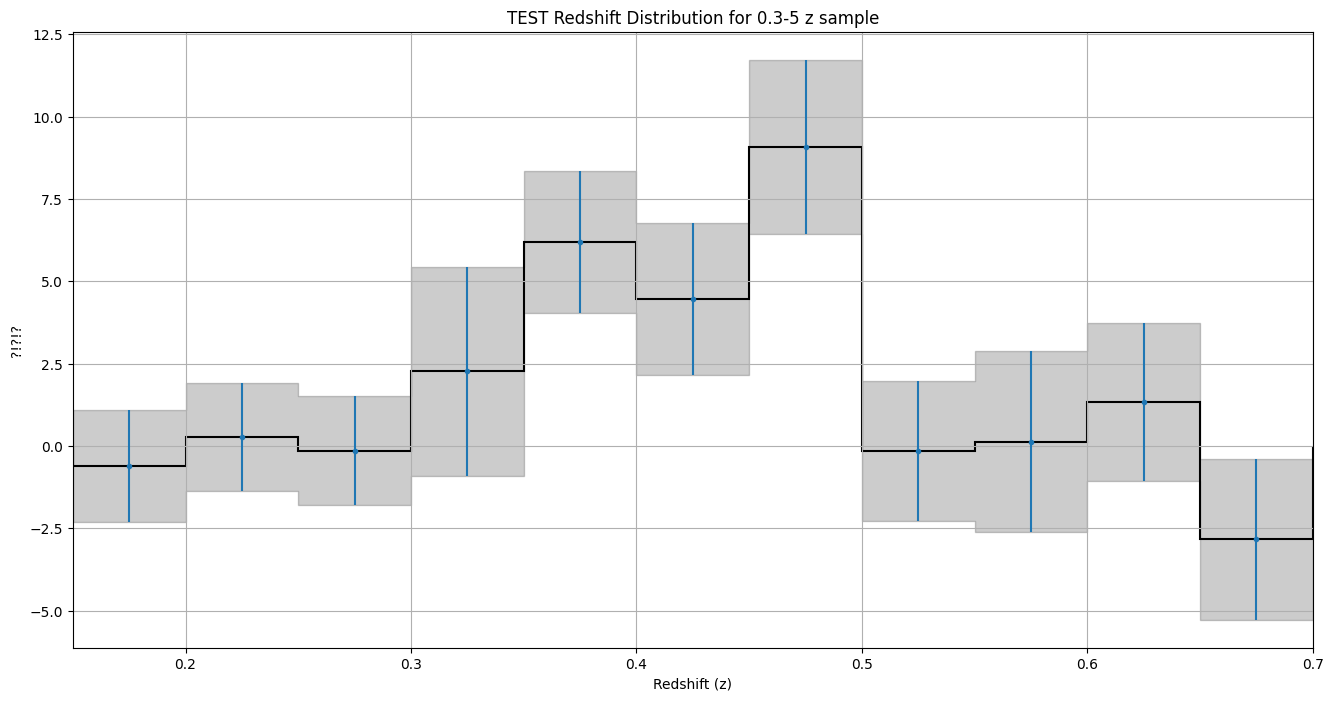

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.title('TEST Redshift Distribution for 0.3-5 z sample')
ncc.normalised().plot(style='point')
#ncc.normalised().plot(style='line')
ncc.normalised().plot(style='step')
plt.xlim(z_min_to_use,z_max_to_use)
plt.grid()
plt.xlabel('Redshift (z)')
plt.ylabel('?!?!?')